In [1]:
import numpy as np
# !pip install cartopy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
dataset = np.load('ERA_wind\ERA_wind.npz')

# prints the file names in the dataset
# print(dataset.files)

In [3]:
lat = dataset.get('lat')  
lon = dataset.get('lon')  
x_grid, y_grid = np.meshgrid(lon, lat, indexing='xy')
x_values = x_grid.flatten()
y_values = y_grid.flatten()

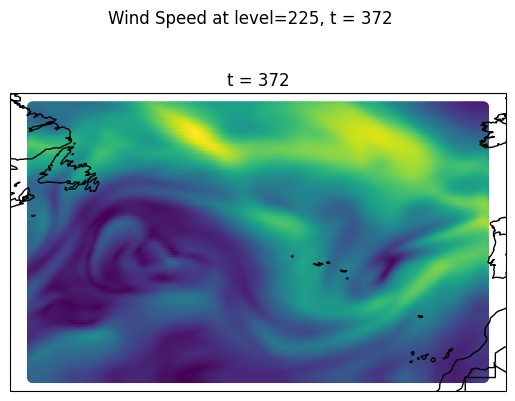

In [4]:
# 744 is the number of timestamps.
# In dataset.get('wind_u')[int(744*r/4)][1], [1] is the level 225.

fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Wind Speed at level=225, t = {}'.format(int(744*2/4)))

r = 2
u = dataset.get('wind_u')[int(744*r/4)][1]
v = dataset.get('wind_v')[int(744*r/4)][1]
wind_speed = np.sqrt(u**2 + v**2)
wind_speed_flat = wind_speed.flatten()

scatter_plot = axs.scatter(x_values, y_values, c=wind_speed_flat, cmap='viridis', s=50, transform=ccrs.PlateCarree())
axs.coastlines()
axs.add_feature(cfeature.BORDERS)
axs.set_title("t = {}".format(int(744*r/4)))

plt.show()

NameError: name 'wind_speed_coarse' is not defined

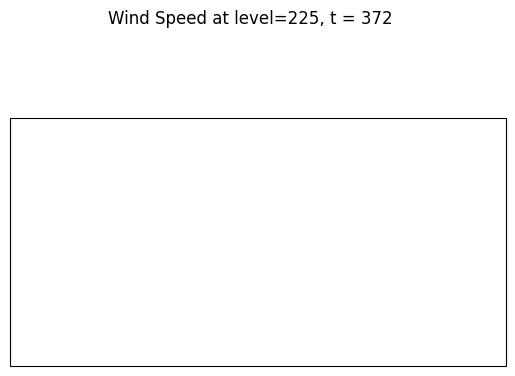

In [5]:
# GPT CODE: Method 1
# Reducing the number of latitude and longitude points by selecting every k-th point from the lat and lon arrays

# Coarsening factor k
k = 8  # For example, choose every second point

# Original data retrieval
lat = dataset.get('lat')
lon = dataset.get('lon')

# Coarsen the resolution by selecting every k-th point
lat_coarse = lat[::k]
lon_coarse = lon[::k]

# Generate the coarsened grid
x_grid_coarse, y_grid_coarse = np.meshgrid(lon_coarse, lat_coarse, indexing='xy')
x_values_coarse = x_grid_coarse.flatten()
y_values_coarse = y_grid_coarse.flatten()

# Assuming the rest of your setup is unchanged
fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Wind Speed at level=225, t = {}'.format(int(744*2/4)))

r = 2
# Retrieve and coarsen wind components
u = dataset.get('wind_u')[int(744*r/4)][1][::k, ::k]  # Coarsen data
v = dataset.get('wind_v')[int(744*r/4)][1][::k, ::k]  # Coarsen data
wind_speed = np.sqrt(u**2 + v**2)
wind_speed_flat = wind_speed.flatten()

mesh_plot = axs.pcolormesh(x_grid_coarse, y_grid_coarse, wind_speed_coarse, cmap='viridis', transform=ccrs.PlateCarree())
axs.coastlines()
axs.add_feature(cfeature.BORDERS)
plt.colorbar(mesh_plot, ax=axs, orientation='vertical', label='Wind Speed')

plt.show()

In [9]:
# GPT Code: Method 2
# Spatial Gridbox Averaging; check if correct.
# Takes the mean of the latitudes and longitudes in each block to determine the "center" of the block

import numpy as np
import os

# Define the directories where you want to save the outputs
plot_output_directory = "coarsened_plot_outputs"
array_output_directory = "coarsened_array_outputs"

# Create the output directories if they don't exist
os.makedirs(plot_output_directory, exist_ok=True)
os.makedirs(array_output_directory, exist_ok=True)


def coarsen_with_averaging(data, k):
    """
    Coarsen data by averaging over kxk blocks.
    Assumes data is a 2D array.
    """
    nrows, ncols = data.shape
    nrows_coarse = nrows // k
    ncols_coarse = ncols // k
    data_coarse = np.zeros((nrows_coarse, ncols_coarse))
    for i in range(nrows_coarse):
        for j in range(ncols_coarse):
            data_block = data[i*k:(i+1)*k, j*k:(j+1)*k]
            data_coarse[i, j] = np.mean(data_block)
    return data_coarse

def average_blocks(arr, k):
    """Averages non-overlapping kxk blocks of arr."""
    end = k * (len(arr) // k)
    return arr[:end].reshape(-1, k).mean(axis=1)

k = 8  # Example coarsening factor

def average_blocks(arr, k):
    """Averages non-overlapping kxk blocks of arr."""
    end = k * (len(arr) // k)
    return arr[:end].reshape(-1, k).mean(axis=1)

for t in range(744):
    # Coarsen wind components
    
    u_coarse = coarsen_with_averaging(dataset.get('wind_u')[t][1], k)
    v_coarse = coarsen_with_averaging(dataset.get('wind_v')[t][1], k)
    wind_speed_coarse = np.sqrt(u_coarse**2 + v_coarse**2)

    # Coarsen latitude and longitude
    lat_coarse = average_blocks(lat, k)
    lon_coarse = average_blocks(lon, k)
    x_grid_coarse, y_grid_coarse = np.meshgrid(lon_coarse, lat_coarse, indexing='xy')

    # Save wind_speed_coarse as numpy array
    np.save(os.path.join(array_output_directory, f'wind_speed_coarse_t{t}.npy'), wind_speed_coarse)

    # Plot coarsened wind speed
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle('Coarsened Wind Speed at level=225, t = {}'.format(t))

    mesh_plot = axs.pcolormesh(x_grid_coarse, y_grid_coarse, wind_speed_coarse, cmap='viridis', transform=ccrs.PlateCarree())
    axs.coastlines()
    axs.add_feature(cfeature.BORDERS)
    plt.colorbar(mesh_plot, ax=axs, orientation='vertical', label='Wind Speed')

    # Save the plot to the corresponding folder
    output_filename = os.path.join(plot_output_directory, 'coarsened_wind_speed_t{}.png'.format(t))
    plt.savefig(output_filename)
    plt.close()  # Close the current plot to free memory